In [103]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical


# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import glob
import numpy as np
from tqdm import tqdm
import IPython.display as ipd

In [104]:
# upload the data
classes = pd.read_csv('UrbanSound8K.csv')

In [105]:
classes[["class", "classID"]]

,class,classID
0,dog_bark,3
1,children_playing,2
2,children_playing,2
3,children_playing,2
4,children_playing,2
...,...,...
8727,car_horn,1
8728,car_horn,1
8729,car_horn,1
8730,car_horn,1


In [106]:
classes_code = {v:k for k,v in zip(classes["class"], classes["classID"])}
# A dictionnary doesn't accept double values
print(classes_code)

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


In [107]:
# let's check how many folders we have
glob.glob('urban_dataset//**')

['urban_dataset\\fold1',
 'urban_dataset\\fold10',
 'urban_dataset\\fold2',
 'urban_dataset\\fold3',
 'urban_dataset\\fold4',
 'urban_dataset\\fold5',
 'urban_dataset\\fold6',
 'urban_dataset\\fold7',
 'urban_dataset\\fold8',
 'urban_dataset\\fold9']

In [108]:
ipd.Audio(dataset.file_name.iloc[0])

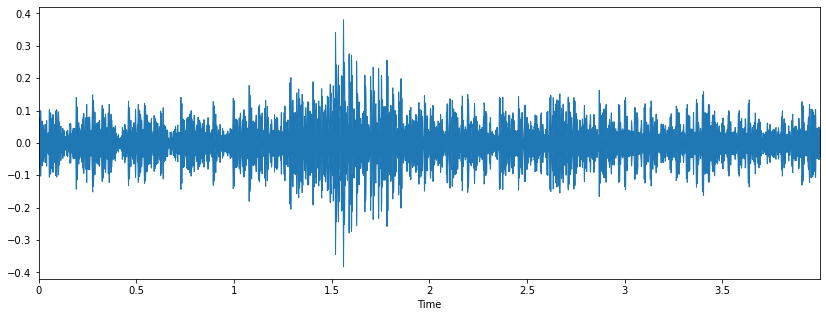

In [109]:
# how to show a wave using liborsa
wave, sample_rate = librosa.load(dataset.file_name.iloc[0], duration = 4)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(wave, sr = sample_rate)
plt.show()

In [110]:
print("Shape of the data",wave.shape)
print("The frequence", sample_rate)
print("Data type is ",wave.dtype)
print("We are hearing the sound of ",classes_code[int(dataset.label.iloc[0])])

Shape of the data (88200,)
The frequence 22050
Data type is  float32
We are hearing the sound of  engine_idling


In [111]:
# Building our dataset
dataset = list()
for folder in glob.glob('urban_dataset//**'):
    list_sounds_path = glob.glob(folder+"//**")
    for elm in list_sounds_path:
        label = elm.split(".wav")[0][-5]
        if label == '-':
            label = elm.split(".wav")[0][-6]
        dataset.append({"file_name" : elm,
                       "label" : label})
        pass
    pass
pass
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state = 42)

In [112]:
dataset.head()

,file_name,label
6770,urban_dataset\fold7\201988-5-0-21.wav,5
3534,urban_dataset\fold4\110621-7-0-1.wav,7
8556,urban_dataset\fold9\58937-4-0-0.wav,4
7870,urban_dataset\fold8\76266-2-0-55.wav,2
1226,urban_dataset\fold10\171478-9-0-4.wav,9


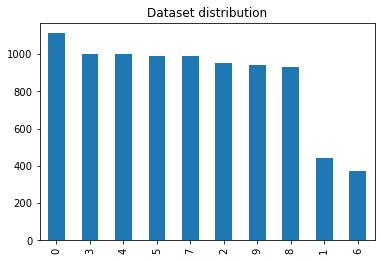

In [113]:
dataset['label'].value_counts().plot(kind = "bar", title="Dataset distribution")
plt.show()

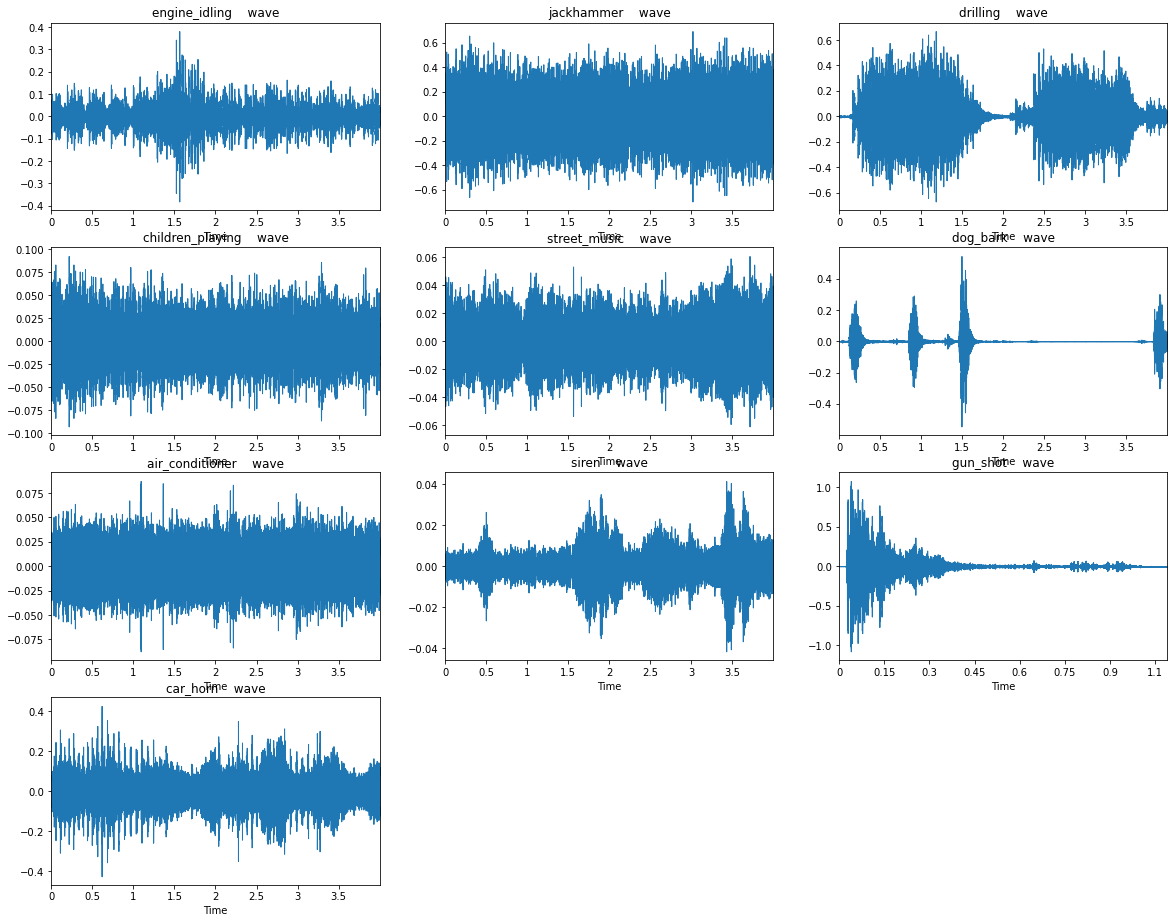

Wall time: 4.57 s


In [114]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].file_name.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s    wave" % classes_code[int(label)])
    librosa.display.waveplot(y, sr=sr)
plt.show()

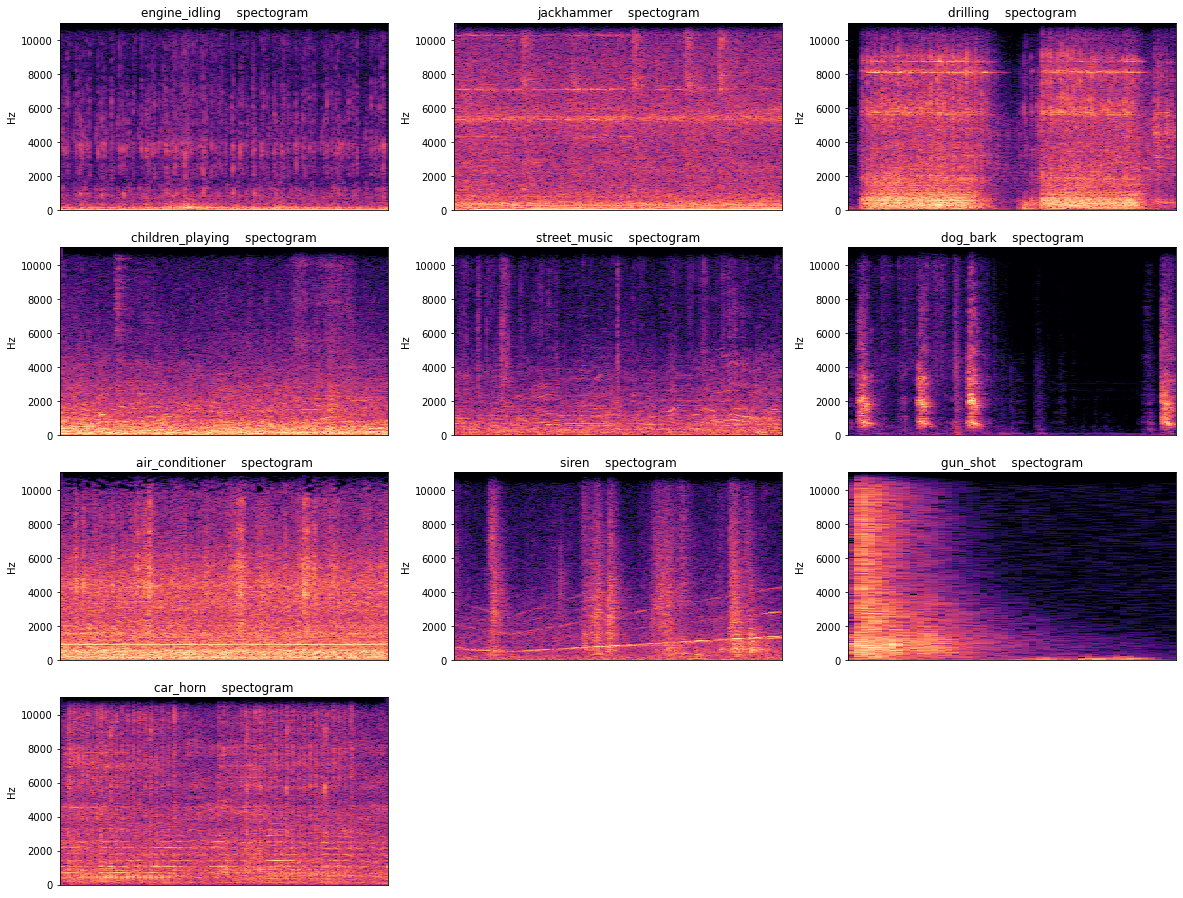

Wall time: 3.21 s


'\n    A spectrogram is a visual way of representing the signal strength, or “loudness”, \n    of a signal over time at various frequencies present in a particular waveform. \n    Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, \n    but one can also see how energy levels vary over time.\n\n'

In [115]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label==label].file_name.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s    spectogram" %classes_code[int(label)])

plt.show()

"""
    A spectrogram is a visual way of representing the signal strength, or “loudness”, 
    of a signal over time at various frequencies present in a particular waveform. 
    Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, 
    but one can also see how energy levels vary over time.

"""

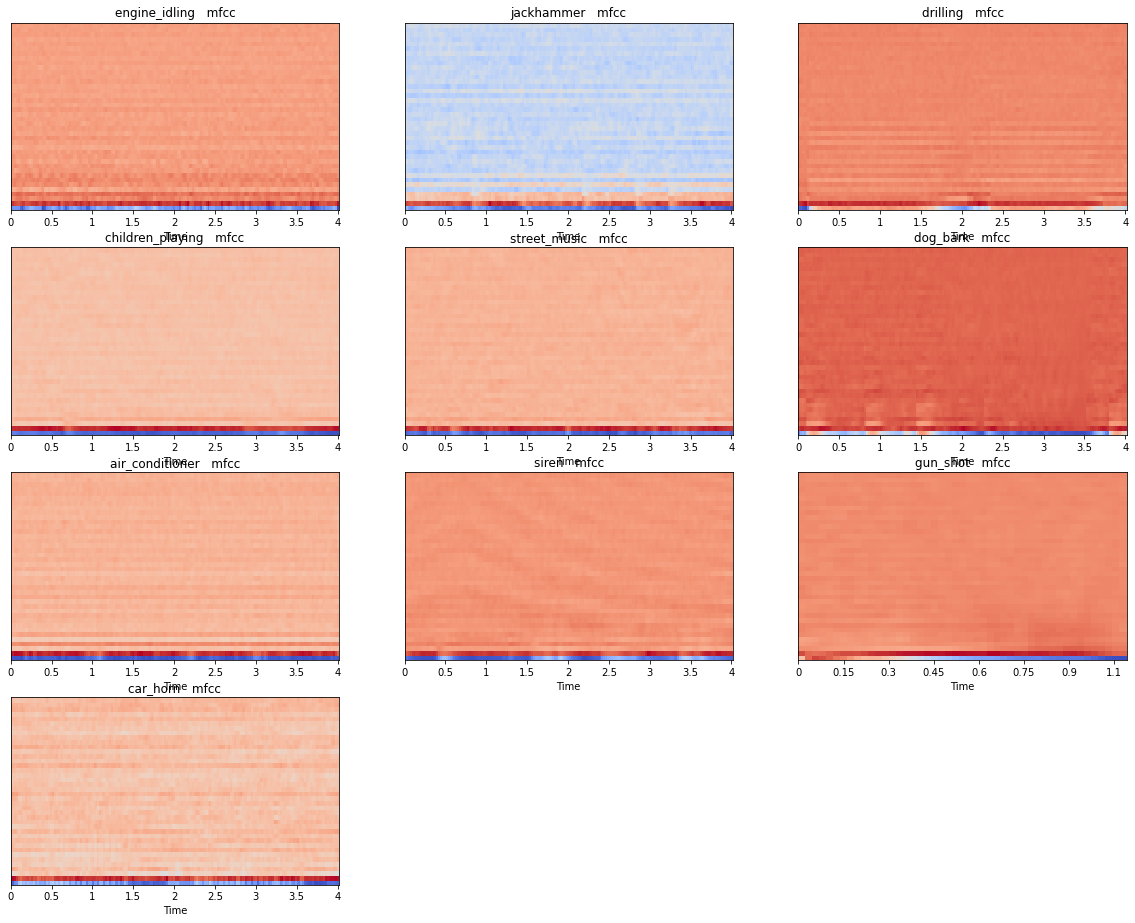

Wall time: 2.79 s


'\n    Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. \n    They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). ... \n    MFCCs are commonly derived as follows: Take the Fourier transform of (a windowed excerpt of) a signal.\n\n'

In [116]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label==label].file_name.iloc[0], duration=4)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s   mfcc" % classes_code[int(label)])

plt.show()
"""
    Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. 
    They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). ... 
    MFCCs are commonly derived as follows: Take the Fourier transform of (a windowed excerpt of) a signal.

"""

In [119]:
# generating training and testing datasets 
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)

In [120]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration = 4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return mfccs

In [121]:
x_train, x_test = list(), list()

print("Extract features from TRAIN  and TEST dataset")
for i in tqdm(range(len(train))):
    x_train.append(extract_features(dataset.file_name.iloc[i]))
    pass
pass

  0%|                                                                                 | 1/6985 [00:00<17:05,  6.81it/s]

Extract features from TRAIN  and TEST dataset


 13%|██████████▏                                                                    | 905/6985 [02:54<24:27,  4.14it/s]C:\Users\Supernova\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
 24%|██████████████████▊                                                           | 1687/6985 [05:26<17:21,  5.09it/s]C:\Users\Supernova\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
 82%|███████████████████████████████████████████████████████████████▊              | 5710/6985 [18:48<05:33,  3.82it/s]C:\Users\Supernova\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
  0%|                                                                                         | 0/1747 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'filename'

In [122]:
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(dataset.file_name.iloc[idx]))
    pass
pass

 52%|████████████████████████████████████████▉                                      | 905/1747 [03:17<03:13,  4.36it/s]C:\Users\Supernova\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
 97%|███████████████████████████████████████████████████████████████████████████▎  | 1687/1747 [05:54<00:13,  4.33it/s]C:\Users\Supernova\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1747/1747 [06:08<00:00,  4.75it/s]


In [132]:
print(len(x_test), len(x_train))

1747 6985


# Deep learning model

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)